# *WORKING file:* Species abundance model
### Description:
Create a tutorial for a marine species abundance model in python. This notebook was created at the PACE Hackweek 2025. Our use-case will be with [NOAA NEFSC bottom trawl](https://www.fisheries.noaa.gov/new-england-mid-atlantic/science-data/2025-spring-bottom-trawl-survey-completed-northeast) data, specifically longfin squid.


![longfin squid!](https://img.freepik.com/free-vector/hand-drawn-squid-illustration_23-2149560574.jpg?semt=ais_hybrid&w=740&q=80)
### Authors (alphabetical): 
* Artem Dzhulai (URI)
* Eli Holmes (NOAA Fisheries) 
* Sajna Hussain (Oregon State)
* Jamon Jordan (Oregon State)
* Natalie McCourt (UMBC)
* Haley Synan (NOAA Fisheries/IBSS)

### History:
>* *8/4/25: notebook initialized, code added to stream pace and glorys data*
>* *8/5/25: pace match functions added, glorys matchup functions added*


##### To get push access to SDM repo:
CD to local repo directory. Run ```gh-scoped-creds``` in the terimal and follow instructions.

## Contents 
1. [Work with fisheries Data](#1.-Work-with-fisheries-data)
2. [Load and match PACE Data](#2.-Load-and-match-PACE-data)
3. [Load and match GLORYS Data](#3.-Load-and-match-GLORYS-data)
4. [Create SDM model!](#4.-Create-SDM-model!)
5. [Visualize results](#5.-Visualize-results)

# STEPS
* [x] Get fisheries data
* [x] Preliminary analysis of ALL species abundance
* [x] Match the PACE data
* [x] Match GLORYS data 
* [x] Choose explanatory variables
    * AVW
    * RRS_brightness
    * CHL
* [x] Match data
* [ ] Run model (xgboost) 

In [1]:
!pip install copernicusmarine

  Using cached copernicusmarine-2.2.1-py3-none-any.whl.metadata (8.2 kB)
  Using cached arcosparse-0.4.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached pystac-1.13.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached semver-3.0.4-py3-none-any.whl.metadata (6.8 kB)
  Using cached pydantic_core-2.33.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
Using cached copernicusmarine-2.2.1-py3-none-any.whl (115 kB)
Using cached arcosparse-0.4.2-py3-none-any.whl (26 kB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
Using cached pydantic_core-2.33.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached pystac-1.13.0-py3-none-any.whl (206 kB)
Using cached semver-3.0.4-py3-none-any.whl (17 kB)
Using cached typing_inspection-0.4.1-py3-none-any.whl (14 kB)
  Attempting uninstall: pydantic-core
   

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
import earthaccess
from match_func import match_nearest
import cmocean
import netCDF4
import h5netcdf
import copernicusmarine
import geopandas as gpd
import earthaccess
import xarray as xr
import cartopy.feature as cfeature
from shapely.ops import unary_union
auth = earthaccess.login(persist=True)

## 1. Work with fisheries data

In [3]:
os.chdir(r'/home/jovyan/Hackweek2025/proj_2025_sdm/data')
trawl_df = pd.read_csv('fisheries_with_pace_rrs_avw2.csv') #read data 
# --- Data Cleaning (Crucial Step!) ---

# 1. Ensure the date column is a proper datetime object.
#    This is vital for matching with the environmental data.
trawl_df['TOWDATETIME_EST'] = pd.to_datetime(trawl_df['TOWDATETIME_EST'])

# 2. Ensure coordinates are numeric
trawl_df['LON'] = pd.to_numeric(trawl_df['LON'])
trawl_df['LAT'] = pd.to_numeric(trawl_df['LAT'])

# Display the first few rows and data types to verify
print("Catch Data Head:")
print(trawl_df.head())
print("\nData Types:")
print(trawl_df.info())

# --- Standardize Column Names to Match Xarray Dims ---
# This is the crucial step to ensure congruency.
rename_dict = {
    'TOWDATETIME_EST': 'time',
    'LAT': 'latitude',
    'LON': 'longitude'
}
trawl_df = trawl_df.rename(columns=rename_dict)

Catch Data Head:
      TOWDATETIME_EST        LAT        LON  MEAN_DEPTH  SWEPT_AREA_km  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24       0.021282   
1 2024-03-07 14:32:00  38.498596 -74.477395          40       0.024311   
2 2024-03-07 17:44:00  38.411974 -74.502885          39       0.023835   
3 2024-03-07 20:29:00  38.505238 -74.832046          25       0.021510   
4 2024-03-07 22:45:00  38.556784 -74.897495          21       0.019174   

   acadian redfish  alewife  alligatorfish  american lobster  american plaice  \
0              0.0      0.0            0.0               0.0              0.0   
1              0.0      0.0            0.0               0.0              0.0   
2              0.0      0.0            0.0               0.0              0.0   
3              0.0      0.0            0.0               1.0              0.0   
4              0.0      0.0            0.0              27.0              0.0   

   ...   Rrs_707   Rrs_708   Rrs_709   Rrs_711   Rr

## Data exploration
We want to find a species (or few) that would be the most useful to model. We will sort the species by total number of observations over the entire survey. We will plot that as a faux time series, using station number instead of datetime. Then we will find species that have more than 50,000 observations over the survey period. This is a crude way to remove the species that were rarely seen and wouldn't be a good fit to model. 

/tmp/ipykernel_155/79794507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['station'] = np.arange(1,len(sub)+1) #add station col


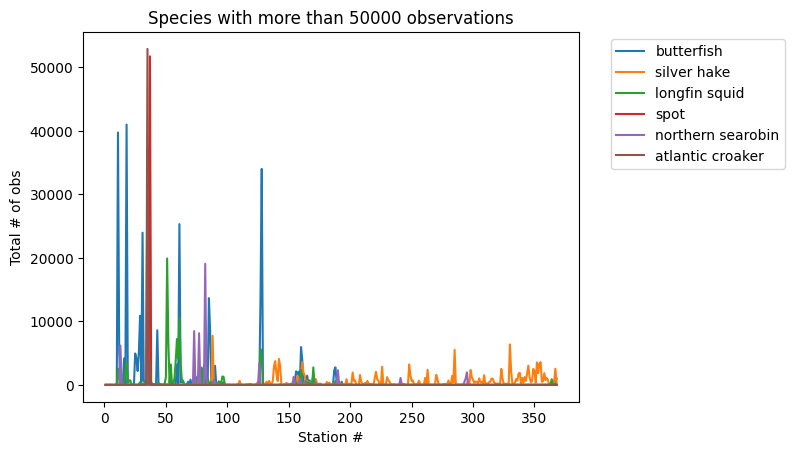

In [4]:
matched=[]
for item in trawl_df.columns:
    if 'Rrs' in item:  # Using the 'in' operator for substring check
        pass
    else: 
        matched.append(item)

sub = trawl_df[list(matched)] #subset (remove RRS columns) 
sub['station'] = np.arange(1,len(sub)+1) #add station col

tot_sum = {}
for s in sub.columns[5:-2]:
   tot_sum.update({s:int(sub[s].sum())})  #get total sum of all values 

sorted_tot_sum = sorted(tot_sum.items(), key=lambda item: item[1],reverse=True) #sort by max-->min


abu=[]
for val in sorted_tot_sum:
    if val[1]>50000: #if more than 50000 observations 
        abu.append(val[0])


#plot max valeus 
for s in sub[abu].columns:
    plt.plot(sub.station, sub[s],label=s)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.xlabel('Station #')
plt.ylabel('Total # of obs')
plt.title('Species with more than 50000 observations')
plt.show()

Now we have the 6 most dominant (in total # of obs) over the survey period. We 

In [ ]:
min_lat = trawl_df['latitude'].min()
max_lat = trawl_df['latitude'].max()
min_lon = trawl_df['longitude'].min()
max_lon = trawl_df['longitude'].max()

# Print DataFrame shape and columns (for trawl_df)
print("\n--- Trawl Data Shape and Columns ---")
print("Trawl DataFrame Shape:", trawl_df.shape)
print("Trawl DataFrame Columns:", trawl_df.columns.tolist())


print(f"Trawl data latitude range: {min_lat} to {max_lat}")
print(f"Trawl data longitude range: {min_lon} to {max_lon}")
print("Trawl Data Time Range:", trawl_df["time"].min(), "to", trawl_df["time"].max())

Text(0.5, 0.98, 'Species presence by station')

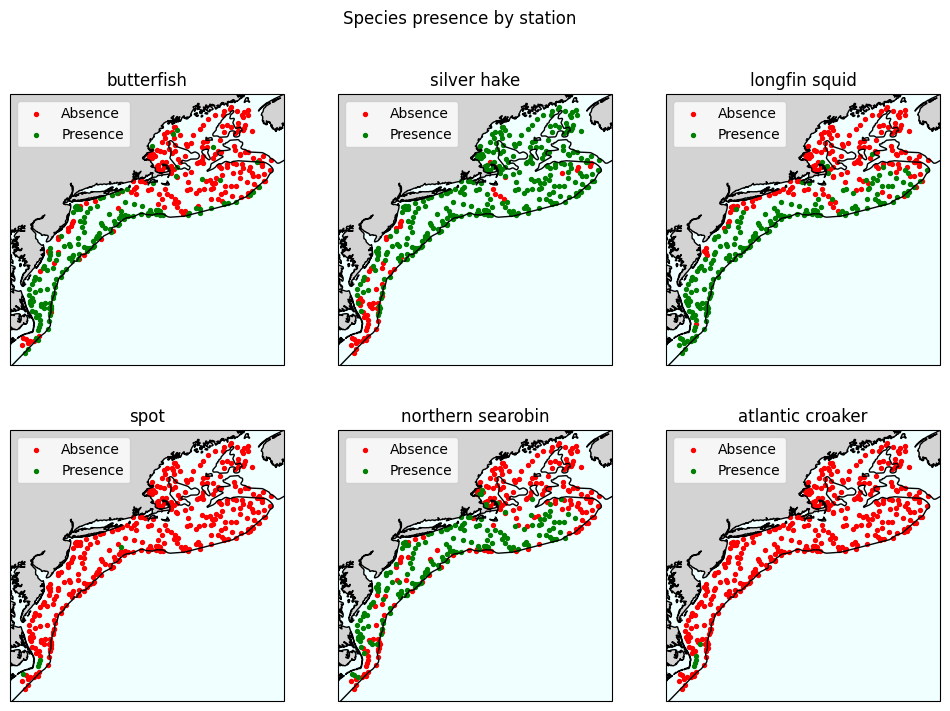

In [5]:
# Create a figure and a 3x2 grid of subplots
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 8),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

# Example data for plotting
x = np.linspace(0, 10, 100)

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    ax.scatter(sub[sub[sub[abu].columns[i]]==0].longitude, sub[sub[sub[abu].columns[i]]==0].latitude,c='r',s=8,label='Absence')
    ax.scatter(sub[sub[sub[abu].columns[i]]!=0].longitude, sub[sub[sub[abu].columns[i]]!=0].latitude,c='g',s=8,label='Presence')
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    ax.set_title(sub[abu].columns[i])
    ax.legend()
fig.suptitle('Species presence by station')

## 2. Load and match PACE data
We will be using chlorophyll, avw, and RRS brightness

In [6]:
def get_pace_path(trawl_df, short_name):
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.8*.4km*")
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 


def open_pace(paths): 
    d8=[]
    for file in paths: 
        d = xr.open_dataset(file)
        d8.append(d.attrs['time_coverage_start'])
    ds = xr.open_mfdataset(paths, combine='nested',concat_dim='datetime').assign_coords({'time':d8}) #add new dimension and assign time data to it
    ds = ds.rename({'datetime':'time'}) #rename to time
    ds = ds.where((ds.lat > 34.40918) & (ds.lat < 46.362305) & (-63>ds.lon) & (-77< ds.lon),drop=True) #general spatial subset
    ds = ds.rename({'lat':'latitude','lon':'longitude'})
    #ds['time']=[pd.to_datetime(d) for d in ds.time.values] #convert to pandas datetime 
    ds['time'] = pd.to_datetime(ds.time) #convert to pandas datetime 
    return ds

#trawl_df pre-processing
trawl_df['date'] = [str(d).split(' ')[0] for d in trawl_df.time] 
#trawl_df['time'] = [pd.to_datetime(d.replace(' ','T')) for d in trawl_df.TOWDATETIME_EST] #format as timestamp

#get pace data 
paths_avw= get_pace_path(trawl_df,"PACE_OCI_L3M_AVW")
paths_chl= get_pace_path(trawl_df,"PACE_OCI_L3M_CHL")
paths_kd= get_pace_path(trawl_df,"PACE_OCI_L3M_KD")


ds_avw, ds_chl = list(map(open_pace,[paths_avw, paths_chl])) #get path values for each variable 

#match data 
data=[ds_avw, ds_chl] #list of datasets
var_names =['avw','chlor_a'] #list of variable names 
for d in range(len(data)): 
    if d == 0: 
        trawl_df = match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time) #get full trawl_df + avw 
    else: 
        trawl_df[var_names[d]]=match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time)[var_names[d]] #add chl in 
    
# Check for any missing values, which could indicate a mismatch
print("\nMissing values count:")
print(trawl_df[final_columns].isnull().sum())

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

,avw,time,latitude,longitude,MEAN_DEPTH,SWEPT_AREA_km,acadian redfish,alewife,alligatorfish,american lobster,...,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719,Rrs_brightness,date,chlor_a
0,506.8169,2024-03-07 10:58:00,38.659194,-74.828083,24,0.021282,0.0,0.0,0.0,0.0,...,0.000797,0.000765,0.000738,0.000717,0.000689,0.000552,0.000540,1.090205,2024-03-07,2.0587218
1,nan,2024-03-07 14:32:00,38.498596,-74.477395,40,0.024311,0.0,0.0,0.0,0.0,...,0.000364,0.000344,0.000333,0.000325,0.000315,0.000229,0.000261,0.907649,2024-03-07,nan
2,nan,2024-03-07 17:44:00,38.411974,-74.502885,39,0.023835,0.0,0.0,0.0,0.0,...,0.000350,0.000330,0.000318,0.000310,0.000292,0.000210,0.000254,0.935354,2024-03-07,nan
3,nan,2024-03-07 20:29:00,38.505238,-74.832046,25,0.021510,0.0,0.0,0.0,1.0,...,0.000632,0.000606,0.000588,0.000574,0.000553,0.000430,0.000434,1.050127,2024-03-07,nan
4,nan,2024-03-07 22:45:00,38.556784,-74.897495,21,0.019174,0.0,0.0,0.0,27.0,...,0.001221,0.001175,0.001134,0.001093,0.001046,0.000848,0.000791,1.327782,2024-03-07,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,511.90198,2024-05-12 12:30:00,41.305711,-70.636614,23,0.018435,0.0,0.0,0.0,0.0,...,0.000266,0.000253,0.000246,0.000243,0.000237,0.000181,0.000218,0.529729,2024-05-12,1.9841743
364,493.188,2024-05-12 18:45:00,40.467061,-71.381195,73,0.022568,0.0,2.0,0.0,2.0,...,0.000150,0.000142,0.000140,0.000137,0.000138,0.000097,0.000150,0.446814,2024-05-12,0.8285737
365,486.04074,2024-05-13 01:19:00,39.618178,-72.027289,219,0.024705,0.0,0.0,0.0,0.0,...,0.000102,0.000094,0.000093,0.000094,0.000095,0.000057,0.000104,0.450264,2024-05-13,0.45518643
366,491.53732,2024-05-13 03:42:00,39.762143,-72.213598,98,0.020737,0.0,1.0,0.0,0.0,...,0.000141,0.000134,0.000134,0.000133,0.000130,0.000068,0.000124,0.446797,2024-05-13,0.7093886


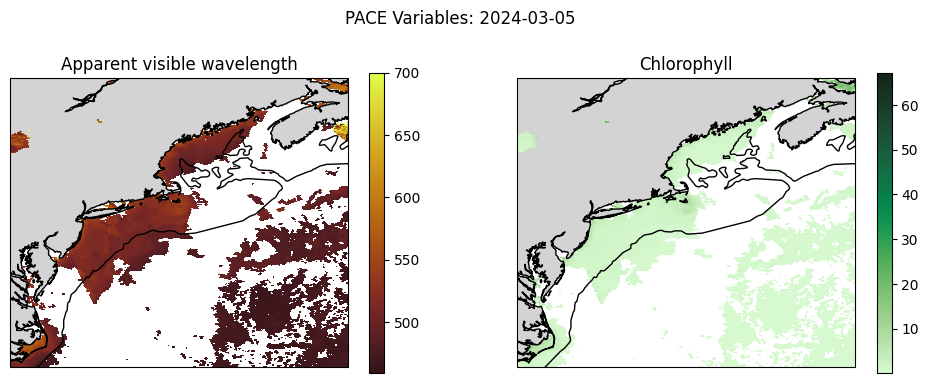

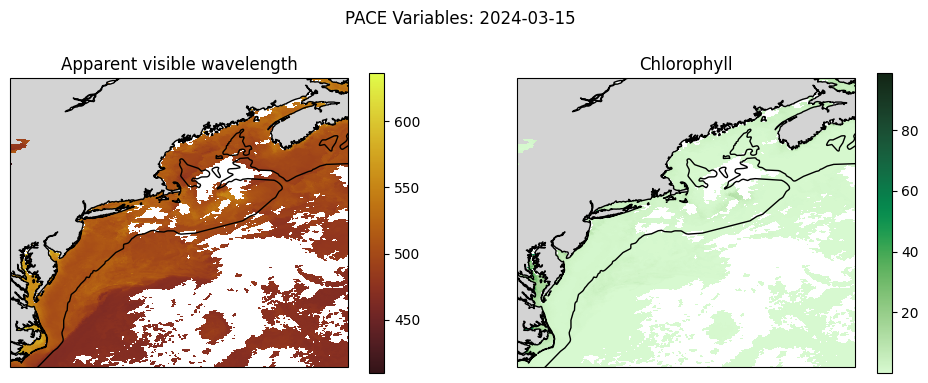

In [80]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))

for i in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

    im=axs[0].pcolormesh(ds_avw.longitude, ds_avw.latitude, ds_avw.avw[i],cmap=cmocean.cm.solar)
    axs[0].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[0].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[0].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[0].set_title('Apparent visible wavelength')
    
    im1=axs[1].pcolormesh(ds_chl.longitude, ds_chl.latitude, ds_chl.chlor_a[i],cmap=cmocean.cm.algae)
    axs[1].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[1].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[1].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[1].set_title('Chlorophyll')
    
    fig.colorbar(im, ax=axs[0],shrink=0.65)
    fig.colorbar(im1, ax=axs[1],shrink=0.65)
    fig.suptitle('PACE Variables: '+ str(ds_avw.time[i].values).split('T')[0],y=0.85)
    fig.show()


## 3. Load and match GLORYS data

In [7]:
glorys_ds= copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_phy_myint_0.083deg_P1D-m',minimum_longitude=-77, maximum_longitude=-63,minimum_latitude=34,maximum_latitude=46,)
glorys_subset = glorys_ds.where((glorys_ds['time.year'] > 2023) & (glorys_ds['time.month']>2)& (glorys_ds['time.month']<6), drop=True)
glorys_subset['time'] = [pd.Timestamp(d) for d in glorys_subset.time.values]

INFO - 2025-08-06T12:37:53Z - Selected dataset version: "202311"
INFO - 2025-08-06T12:37:53Z - Selected dataset part: "default"
INFO - 2025-08-06T12:37:53Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:

  hsynan1


Copernicus Marine password:

  ········


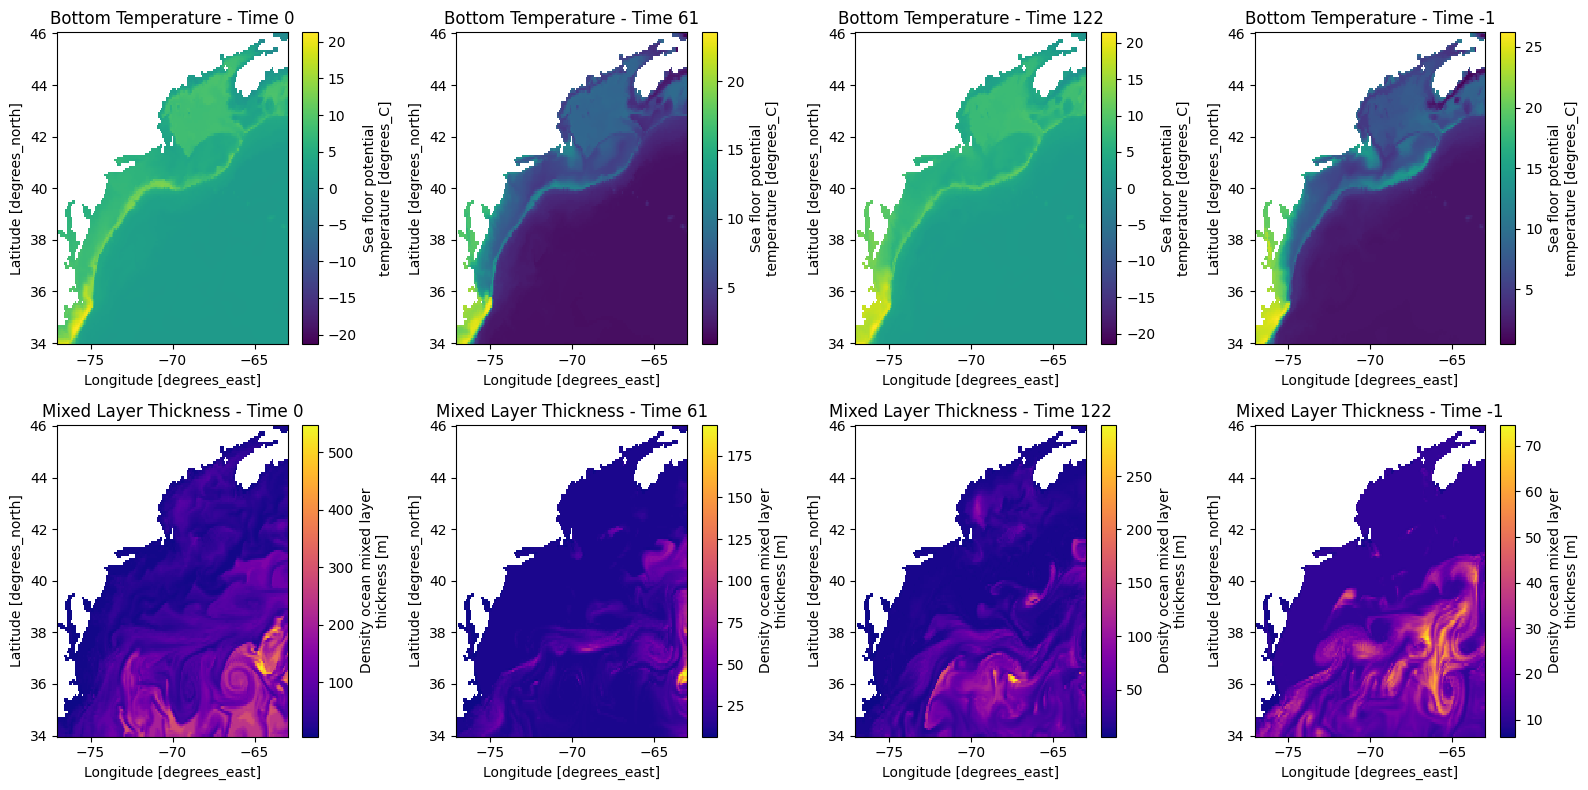

In [8]:
# Select four time slices (modify indices if needed)
time_indices = [0, int(len(glorys_subset.time)/3), int(2*len(glorys_subset.time)/3), -1]

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, t in enumerate(time_indices):
    # Plot 
    ax = axes[0, i]
    glorys_subset.bottomT.isel(time=t).plot(ax=ax, cmap="viridis")
    ax.set_title(f"Bottom Temperature - Time {t}")

    # Plot 2
    ax = axes[1, i]
    glorys_subset.mlotst.isel(time=t).plot(ax=ax, cmap="plasma")
    ax.set_title(f"Mixed Layer Thickness - Time {t}")

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
# --- Vectorized Extraction ---

# 1. Create DataArrays for coordinates from your standardized catch_df.
#    The names 'time', 'latitude', 'longitude' now match the env_ds dimensions.
times = xr.DataArray(trawl_df.time.values, dims="observation")
lats = xr.DataArray(trawl_df.latitude.values, dims="observation")
lons = xr.DataArray(trawl_df.longitude.values, dims="observation")

# 2. Extract the 3D variables (bottomT, mlotst) in one go.
#    These variables don't have a 'depth' dimension.
extracted_3d_data = glorys_subset[['bottomT', 'mlotst']].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
)

# 3. Handle the 4D variable (so) separately to deal with depth.
#    Since it's bottom trawl data, we select the deepest available grid cell.
#    .isel(depth=-1) selects the last element along the depth dimension.
extracted_so = glorys_subset['so'].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
).isel(depth=-1) # Select the bottom-most depth layer

# --- Merge results back into your original DataFrame ---

# Add the extracted 3D variables
trawl_df['bottom_temp'] = extracted_3d_data['bottomT'].values
trawl_df['mld'] = extracted_3d_data['mlotst'].values

# Add the extracted bottom salinity
trawl_df['bottom_salinity'] = extracted_so.values

# --- Display the final merged DataFrame ---
print("\n--- FINAL MERGED DATA ---")
# Displaying relevant columns for verification
final_columns = [
    'time', 'latitude', 'longitude', 'MEAN_DEPTH',
    'bottom_temp', 'mld', 'bottom_salinity'
]
print(trawl_df[final_columns].head())

# Check for any missing values, which could indicate a mismatch
print("\nMissing values count:")
print(trawl_df[final_columns].isnull().sum())


--- FINAL MERGED DATA ---
                 time   latitude  longitude  MEAN_DEPTH  bottom_temp  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24     6.877743   
1 2024-03-07 14:32:00  38.498596 -74.477395          40     7.566973   
2 2024-03-07 17:44:00  38.411974 -74.502885          39     7.698813   
3 2024-03-07 20:29:00  38.505238 -74.832046          25     6.991272   
4 2024-03-07 22:45:00  38.556784 -74.897495          21     6.862362   

         mld  bottom_salinity  
0  10.528886              NaN  
1  10.834071              NaN  
2  10.528886              NaN  
3  10.528886              NaN  
4  10.528886              NaN  

Missing values count:
time                 0
latitude             0
longitude            0
MEAN_DEPTH           0
bottom_temp          1
mld                  1
bottom_salinity    368
dtype: int64


Text(0.5, 0.98, 'Matched variables')

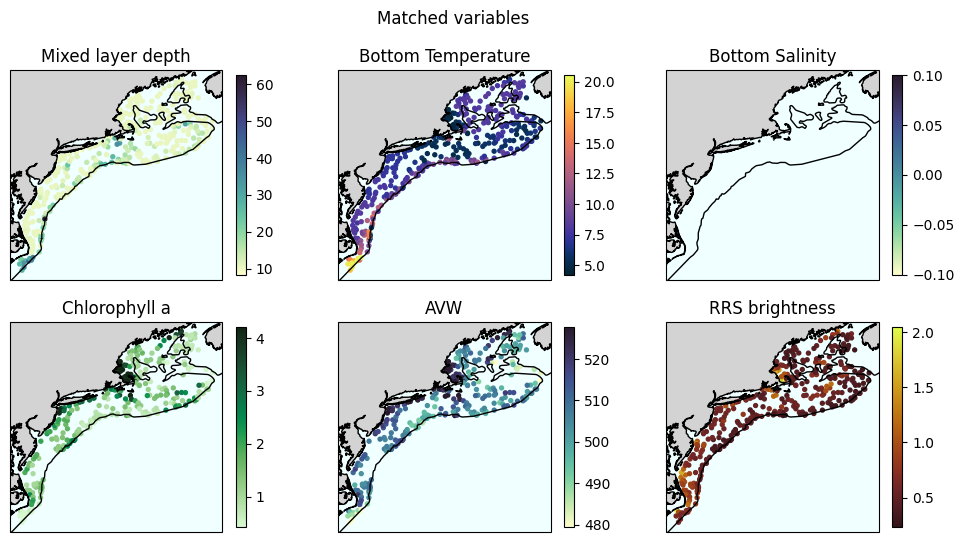

In [50]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

var=['mld','bottom_temp','bottom_salinity','chlor_a','avw','Rrs_brightness']
var_n = ['Mixed layer depth','Bottom Temperature','Bottom Salinity','Chlorophyll a','AVW','RRS brightness']
# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    if var[i] == 'bottom_temp':
        cmap = cmocean.cm.thermal
    elif var[i] =='chlor_a':
        cmap=cmocean.cm.algae
    elif var[i] == 'Rrs_brightness':
        cmap=cmocean.cm.solar
    else: 
        cmap = cmocean.cm.deep
    im=ax.scatter(trawl_df.longitude, trawl_df.latitude, c=trawl_df[var[i]], label=var[i],s=8, cmap=cmap,vmin=trawl_df[var[i]].min(),vmax=trawl_df[var[i]].max(), )
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    fig.colorbar(im, ax=ax,shrink=0.95)
    ax.set_title(var_n[i])
fig.suptitle('Matched variables')

## 4. Create SDM model! 

## 5. Visualize results